In [45]:
''' Import packages. '''
# Time packages
import cftime, datetime, time
# Numerical analysis packages
import numpy as np, random, scipy, numba
# Local data storage packages
import functools, dill, os, pickle, collections
# Data structure packages
import pandas as pd, xarray as xr
xr.set_options(keep_attrs=True)
# Visualization tools
import cartopy, cartopy.crs as ccrs, matplotlib, matplotlib.pyplot as plt
# Local imports
import accessor, composite, composite_snapshots, derived, utilities, socket, visualization, tc_analysis, tc_processing, rotate

import importlib
importlib.reload(composite);
importlib.reload(composite_snapshots);
importlib.reload(utilities);
importlib.reload(tc_analysis);
importlib.reload(tc_processing);
importlib.reload(visualization);
importlib.reload(rotate);
importlib.reload(derived);

In [46]:
def access(models, experiments, fields, year_range, FLOR_year_adjustment=2050):

    '''
    Determine path names for files from which climate model output data will be obtained.

    Args:
    - models (list): list of model names 
    - experiments (list): list of experiment names corresponding to each model
    - fields (list): list of fields from which to obtain data
    - year_range (list or tuple, 2-item): list of years over which to obtain model data
    - FLOR_year_adjustment (int, optional): number of years to adjust data for in FLOR
    Returns:
    - paths (dict): dictionary holding path names for model data, as well as model year ranges. 
                    Dictionary structure is: paths{model: {year_range, path}}
    '''

    # Directory holding post-processed climate model data
    dirname = '/tigress/GEOCLIM/gr7610/analysis/model_out'
    # Initialize data structure to hold pathnames and model year ranges for each model and experiment configuration
    paths = {model: {} for model in models}
    # Find matching data for each model and experiment
    for model in models:
        # Adjust the year range for FLOR runs
        model_year_range = (min(year_range) + FLOR_year_adjustment, max(year_range) + FLOR_year_adjustment) if 'FLOR' in model else year_range
        paths[model]['year_range'] = model_year_range
        # Iterate by experiment
        for experiment in experiments:
            paths[model][experiment] = {}
            for field in fields:
                # Filter files by model, experiment, and field
                filenames = [f for f in os.listdir(dirname) if
                             model in f and 
                             '{0}-'.format(experiment) in f and 
                             field in f and
                             f.endswith('nc')]
                # Filter files to ensure the year range requested is covered by the found data
                filenames = [f for f in filenames if
                             int(f.split('.nc')[0].split('-')[-1].split('_')[0]) <= min(model_year_range) and
                             int(f.split('.nc')[0].split('-')[-1].split('_')[1]) >= max(model_year_range)]
                # Report how many files found for the requested field
                print('{0} files found for the {1} model in the {2} experiment configuration for field {3}...'.format(len(filenames), model, experiment, field))
                paths[model][experiment][field] = os.path.join(dirname, filenames[0]) if len(filenames) > 0 else None

    return paths

In [47]:
def data_load(models: str | list[str], 
              experiments: list[str],
              fields: list[str], 
              year_range: tuple[int, int], 
              difference_experiment: tuple[str, str] | None = False):

    '''
    Loads data for a given list of models, experiments, and fields.

    Args:
    - models (list): list of model names 
    - experiments (list): list of experiment names corresponding to each model
    - fields (list): list of fields from which to obtain data
    - year_range (tuple of int, 2 items): minimum and maximum years for data processing
    - difference_experiment (tuple of str, 2 items; default: False): 
    Returns:
    - data (dict):  dictionary with keys corresponding to model names, subkeys corresponding to experiment names, 
                    and subkey values corresponding to xArray Datasets containing the requested fields
    '''

    # Ensure year range has 2 items
    assert len(year_range) == 2
    # Ensure difference_experiment has 2 items
    assert len(difference_experiment) == 2 or difference_experiment is None

    if isinstance(models, str):
        models = [models]
    
    # Initialize container dictionary
    data = {model: {} for model in models}
    # Obtain path names and model years for the requested models, experiments, and fields
    paths = access(models, experiments, fields, year_range, FLOR_year_adjustment=0)
    # Iterate over each model to load data
    for model in models:
        start_year, end_year = ['{0:04d}-01-01'.format(min(paths[model]['year_range'])), 
                                '{0:04d}-01-01'.format(max(paths[model]['year_range'])+1)]
        for experiment in experiments:
            data[model][experiment] = {}
            # Load data for the given configuration, and slice by time to minimize data loading into memorry
            for field in fields:
                data[model][experiment][field] = xr.open_dataset(paths[model][experiment][field])[field].sel(time=slice(start_year, end_year))
            # Merge dictionary values for each model and experiment pair into an xArray Dataset for a concise data structure
            data[model][experiment] = xr.merge(data[model][experiment].values())

    # Generate the difference experiment dataset based on inputs, iterating over each model
    if difference_experiment:
        for model in models:
            # Assign variable names to difference experiment names
            experiment_CTL, experiment_EXP = difference_experiment
            # Initialize a counter to determine if experiment needed to compute the difference are present
            experiment_name_counter = 0
            for experiment_name in experiments:
                # Increment the field counter for each match found
                experiment_name_counter += 1 if experiment_name in experiments else 0
            if experiment_name_counter == len(experiments):
                experiment_DIFF = f'{experiment_CTL}-{experiment_EXP}'
                data[model][experiment_DIFF] = data[model][experiment_CTL] - data[model][experiment_EXP]
            else:
                print('Not all experiments loaded to compute difference between experiments {0} and {1}. The only experiments loaded are: {2}'.format(experiment_CTL, experiment_EXP, experiments))
    
    return data

In [48]:
def derived_quantities(data):

    '''
    Obtain quantities derived from climate model outputs.
    
    '''

    L = utilities.get_constants('L_v')
    
    # Define requested quantities
    # Dictionary structure is: {field name: {fields needed to compute: list}, 
    #                           function: function to compute the quantity, 
    #                           attributes: {descriptive name of field: name, field units: units}}
    quantities = {'p-e': {'fields': ['precip', 'evap'],
                          'function': lambda x: x['precip'] - x['evap'],
                          'attrs': {'long_name': 'surface freshwater flux',
                                    'units': 'kg m^{-2} s^{-1}'}},
                  'swabs_toa': {'fields': ['swdn_toa', 'swup_toa'],
                          'function': lambda x: x['swdn_toa'] - x['swup_toa'],
                          'attrs': {'long_name': 'absorbed solar radiation, top of atmosphere',
                                    'units': 'W m^{-2}'}},
                  'net_lw': {'fields': ['olr', 'lwdn_sfc', 'lwup_sfc'],
                             'function': lambda x: x['lwup_sfc'] - x['olr'] - x['lwdn_sfc'],
                             'attrs': {'long_name': 'net longwave radiation into atmosphere',
                                       'units': 'W m^{-2}'}},
                  'net_sw': {'fields': ['swdn_toa', 'swup_toa', 'swdn_sfc', 'swup_sfc'],
                             'function': lambda x:  x['swdn_toa'] - x['swup_toa'] - x['swdn_sfc'] + x['swup_sfc'],
                             'attrs': {'long_name': 'net shortwave radiation into atmosphere',
                                       'units': 'W m^{-2}'}},
                  'lp': {'fields': ['precip'],
                         'function': lambda x:  L*x['precip'],
                         'attrs': {'long_name': 'latent heating of condensation',
                                       'units': 'W m^{-2}'}},
                  'q_atm': {'fields': ['precip', 'shflx', 'swdn_toa', 'swup_toa', 'olr', 'lwdn_sfc', 'lwup_sfc'],
                          'function': lambda x: x['lp'] + x['shflx'] + x['net_sw']  + x['net_lw'],
                          'attrs': {'long_name': 'atmospheric heating',
                                    'units': 'W m^{-2}'}}}
    # Iterate over all models and experiments
    for model in data.keys():
        for experiment in data[model].keys():
            for quantity_name, quantity_keys in quantities.items():
                quantity_fields, quantity_function, quantity_attrs = quantity_keys.values()
                # Initialize a counter to determine if fields needed to compute the iterand derived quantity are present
                field_counter = 0
                for quantity_field in quantity_fields:
                    # Increment the field counter for each match found
                    field_counter += 1 if quantity_field in data[model][experiment].data_vars else 0
                # If the number of fields matches the number of loaded quantities, compute and add to data dictionary
                if field_counter == len(quantity_fields):
                    data[model][experiment][quantity_name] = quantity_function(data[model][experiment])
                    data[model][experiment][quantity_name].attrs = quantity_attrs
                # Else, print an output message and don't touch the data dictionary
                else:
                    print('Not all fields loaded to compute {0}. Only fields loaded are: {1}'.format(quantity_name, 
                                                                                                     data[model][experiment].data_vars))

    return data

In [86]:
def zonal_mean(data, 
               model: str, 
               experiment: str, 
               fields: list[str], 
               month_range: tuple[int, int] = (1, 12),
               smoothing: int | float | None = 5,
               difference_experiment: bool = False,
               conserved_field: str | None = None,
               latitude_weighting: bool = True):

    quantile_min, quantile_max = 0.05, 0.95

    def rolling_mean(arr, degrees=2.5):
        rolling_window_size = round(degrees / arr.grid_yt.diff('grid_yt').values[0])
        return arr.rolling(grid_yt=rolling_window_size, center=True).mean()

    # Get year range from the input data
    year_range = data[model][experiment].time.min().item().year, data[model][experiment].time.max().item().year
    # Filter data by month range
    month_range_filter = utilities.month_selector(data[model][experiment]['time.month'], 
                                                  min(month_range),
                                                  max(month_range))
    data[model][experiment] = data[model][experiment].sel(time=month_range_filter)
    
    dataset = {'mean': data[model][experiment].mean('grid_xt', keep_attrs=True).mean('time', keep_attrs=True),
               'min': data[model][experiment].mean('grid_xt', keep_attrs=True).quantile(quantile_min, dim='time', keep_attrs=True),
               'max': data[model][experiment].mean('grid_xt', keep_attrs=True).quantile(quantile_max, dim='time', keep_attrs=True)}

    if not difference_experiment:
        extrema = (min(dataset['min'][fields].min().values()).item(), max(dataset['max'][fields].max().values()).item())
    else:
        extrema = (min(dataset['mean'][fields].min().values()).item(), max(dataset['mean'][fields].max().values()).item())
               
    norm, _ = visualization.norm_cmap(dataset['mean'], extrema=extrema)
    norm_interval = np.diff(norm.boundaries)[0] # get interval of normalization boundaries

    # Perform smoothing if chosen
    plot_dataset = {}
    for statistic in dataset.keys():
        plot_dataset[statistic] = {}
        for field in fields:
            plot_dataset[statistic][field] = rolling_mean(dataset[statistic][field], degrees=smoothing) if smoothing is not None else dataset[field][statistic]
            if latitude_weighting:
                plot_dataset[statistic][field] = plot_dataset[statistic][field] * np.cos(np.deg2rad(plot_dataset[statistic][field].grid_yt))
        
    fig, ax = plt.subplots(figsize=(5, 3), dpi=144)

    ax.axvline(0, c='k', lw=0.5)
    if min(norm.boundaries) < 0 and max(norm.boundaries) > 0:
        ax.axhline(0, c='k', lw=0.5)
    
    linewidth = 2
    for field_index, field_name in enumerate(fields):
        # Modify linestyle if the conserved field is provided and the iterand field name is not it. Else, keep solid.
        # This is intended to highlight the field of interest in an equation and de-emphasize constituent components
        linestyle = '--' if conserved_field is not None and field_name != conserved_field else '-'
        mean_line = ax.plot(plot_dataset['mean'][field_name].grid_yt, 
                            plot_dataset['mean'][field_name], 
                            lw=linewidth, ls=linestyle, label=field_name)
        if not difference_experiment:
            ax.fill_between(plot_dataset['mean'][field_name].grid_yt,
                            y1=plot_dataset['min'][field_name],
                            y2=plot_dataset['max'][field_name],
                            fc=mean_line[0].get_color(), alpha=0.1)    
    
    ax.set_xlim([-90, 90])
    ax.set_ylim(1.25 * np.array([min(norm.boundaries), max(norm.boundaries)]))
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(30))
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(10))
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())

    

    if difference_experiment:
        constituent_experiments = experiment.split('-')
        assert len(constituent_experiments) == 2
        visualization.TC_density_histogram(model, 
                                           constituent_experiments, 
                                           year_range, 
                                           ax, 
                                           month_range=month_range,
                                           orientation='vertical')
    else:
        print(model, experiment, year_range)
        visualization.TC_density_histogram(model, 
                                           experiment, 
                                           year_range, 
                                           ax, 
                                           month_range=month_range,
                                           orientation='vertical')
    
    ax.set_xlabel('Latitude [degrees N]')
    ax.set_ylabel(dataset['mean'][field_name].attrs['units'])
    
    title_str = f'Zonal and time-mean\nModel: {model}; experiment: {experiment};\nyear range: {year_range}, month range: {month_range}'
    ax.set_title(title_str, loc='left', ha='left', va='bottom', fontsize=10)
    
    fig.tight_layout()
    ax_xmin, ax_ymin, ax_xmax, ax_ymax = ax.get_position().extents
    fig.legend(frameon=False, bbox_to_anchor=(ax_xmax, ax_ymax + 0.04), loc='upper left')

    return dataset

In [90]:
importlib.reload(utilities)
model_name = 'FLOR'
experiments = ['CTL1990s_FA', 'CTL1990s_swishe_FA']
fields = ['netrad_toa', 'swdn_toa', 'swup_toa', 'swdn_sfc', 'swup_sfc', 'lwdn_sfc', 'lwup_sfc', 'olr', 'precip', 'evap', 'shflx', 'WVP']
year_range = (2001, 2100)
data = data_load(model_name, experiments, fields, year_range=year_range, difference_experiment=(experiments[0], experiments[1]))
data = derived_quantities(data)
data = utilities.field_correction(data)

1 files found for the FLOR model in the CTL1990s_FA experiment configuration for field netrad_toa...
1 files found for the FLOR model in the CTL1990s_FA experiment configuration for field swdn_toa...
1 files found for the FLOR model in the CTL1990s_FA experiment configuration for field swup_toa...
1 files found for the FLOR model in the CTL1990s_FA experiment configuration for field swdn_sfc...
1 files found for the FLOR model in the CTL1990s_FA experiment configuration for field swup_sfc...
1 files found for the FLOR model in the CTL1990s_FA experiment configuration for field lwdn_sfc...
1 files found for the FLOR model in the CTL1990s_FA experiment configuration for field lwup_sfc...
1 files found for the FLOR model in the CTL1990s_FA experiment configuration for field olr...
1 files found for the FLOR model in the CTL1990s_FA experiment configuration for field precip...
1 files found for the FLOR model in the CTL1990s_FA experiment configuration for field evap...
1 files found for t

#### Net radiation, TOA
This cell computes timeseries of components of the quantity $R_{\mathrm{TOA}}$.
<br/><br/>
__Governing equation__: 
<br/> $R_{\mathrm{TOA}} = R_{\mathrm{SW, in}} - \mathrm{OLR} = \left( R_{\mathrm{SW, dn}} - R_{\mathrm{SW, up}} \right) - \mathrm{OLR}$

#### TOA radiation, zonal means
This cell computes zonal mean TOA radiation components, as in Hartmann (2016), Fig 2.12.

FLOR CTL1990s_FA (2001, 2100)
Loading data for FLOR, experiment CTL1990s_FA from /projects/GEOCLIM/gr7610/analysis/tc_storage/track_data/TC_track_data.s1901_e2100.model_FLOR.experiment_CTL1990s_FA.pkl...
-------------------------------------------------------------
Statistics for TCs in model: FLOR; experiment: CTL1990s_FA
Number of storms: 2454
Storm duration: mean = 8.27 +/- 4.31 days
Storm maximum winds: mean = 27.44 +/- 5.26 m/s
Storm minimum pressure: mean = 981.85 +/- 16.00 hPa
-------------------------------------------------------------

FLOR CTL1990s_swishe_FA (2001, 2100)
Loading data for FLOR, experiment CTL1990s_swishe_FA from /projects/GEOCLIM/gr7610/analysis/tc_storage/track_data/TC_track_data.s2001_e2100.model_FLOR.experiment_CTL1990s_swishe_FA.pkl...
-------------------------------------------------------------
Statistics for TCs in model: FLOR; experiment: CTL1990s_swishe_FA
Number of storms: 839
Storm duration: mean = 8.40 +/- 4.63 days
Storm maximum winds: mean = 22.

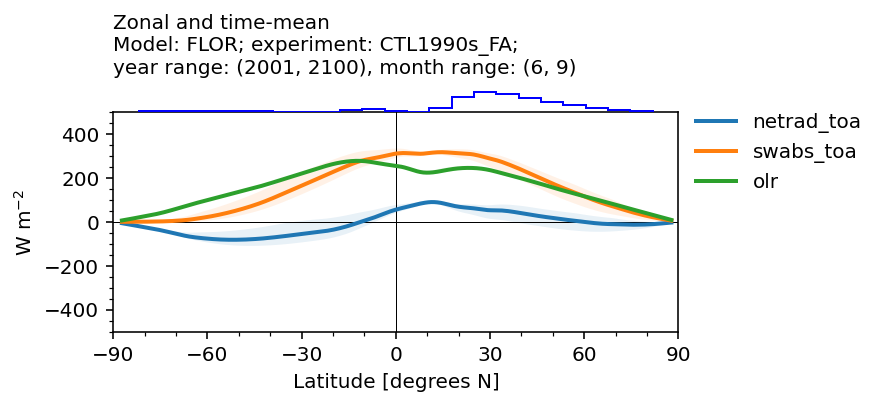

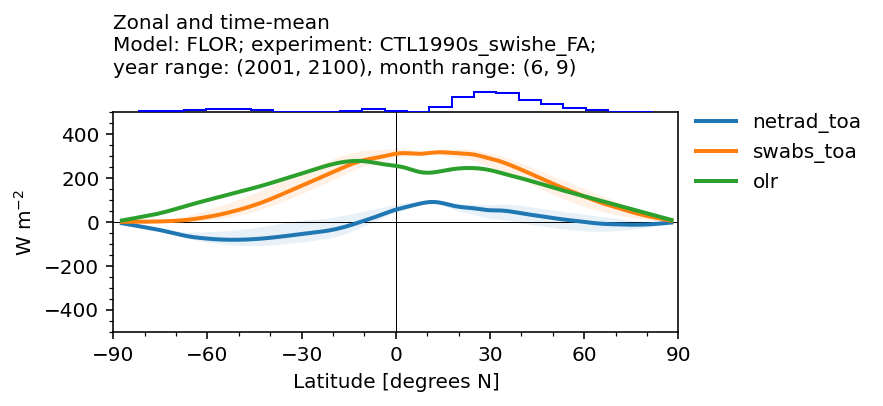

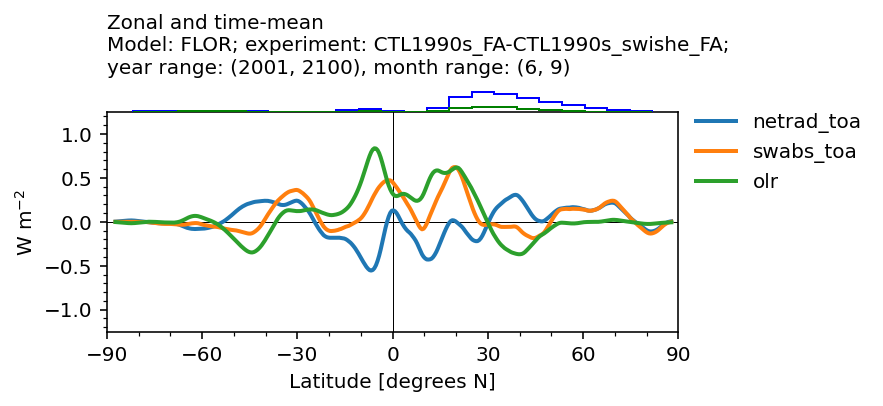

In [95]:
experiment_CTL, experiment_EXP, experiment_DIFF = data[model_name].keys()
fields = ['netrad_toa', 'swabs_toa', 'olr']
conserved_field = None
month_range = (6, 9)

for experiment in [experiment_CTL, experiment_EXP, experiment_DIFF]:
    difference_experiment = True if experiment == experiment_DIFF else False
    zonal_average_radiation = zonal_mean(data, 
                                         model_name, 
                                         experiment, 
                                         fields, 
                                         month_range=month_range,
                                         difference_experiment=difference_experiment)

    # Conservation check
    if conserved_field is not None:
        dataset = zonal_average_radiation['mean'][conserved_field]
        area_weighted_dataset = utilities.latitude_weighting(dataset) * dataset
        print('Conserved field: {0} global mean = {1:.2f} {2} for experiment {3}'.format(conserved_field, area_weighted_dataset.mean(), dataset.attrs['units'], experiment))

#### Atmospheric heating
This cell computes timeseries of components in the quantity $Q_{\mathrm{atm}}$. Sign convention is positive for heating directed into the atmosphere (downwelling from TOA, upwelling from surface). This quantity is approximately conserved globally. In global energy balance, $Q_{\mathrm{atm}} \approxeq 0$.
<br/> <br/>
__Governing equation__: <br/> $Q_{\mathrm{atm}} = \mathrm{LP} + \mathrm{SH} + Q_{\mathrm{SW, net}} + Q_{\mathrm{LW, net}}$, and expanded: <br/>
$Q_{\mathrm{atm}} = \mathrm{LP} + \mathrm{SH} + \left( R_{\mathrm{SW, TOA, dn}} - R_{\mathrm{SW, TOA, up}} - R_{\mathrm{SW, sfc, dn}} + R_{\mathrm{SW, sfc, up}} \right) + \left( 0 - R_{\mathrm{LW, TOA, up}} - R_{\mathrm{LW, sfc, dn}} + R_{\mathrm{LW, sfc, up}} \right)$
<br/> <br/>
__Budget term descriptions__
- $\mathrm{LP}$: latent heating from precipitation
- $\mathrm{SH}$: surface sensible heat flux. `SH` can be considered a proxy of air-sea temperature difference.
- $R_{\mathrm{SW, TOA, dn}}$: downwelling shortwave radiation at TOA. This is also known as solar insolation and remains constant.
- $R_{\mathrm{SW, TOA, up}}$: upwelling shortwave radiation at TOA. This is also known as solar insolation and remains constant.
- $R_{\mathrm{SW, sfc, dn}}$: downwelling shortwave radiation at the surface.
- $R_{\mathrm{SW, sfc, up}}$: upwelling shortwave radiation at the surface.
- $R_{\mathrm{LW, TOA, up}}$: upwelling longwave radiation at TOA. This is also known as outgoing longwave radiation, or `OLR`.
- $R_{\mathrm{LW, sfc, dn}}$: downwelling longwave radiation at the surface.
- $R_{\mathrm{LW, sfc, up}}$: upwelling longwave radiation at the surface. This is a function of surface temperature.

FLOR CTL1990s_FA (2001, 2100)
Loading data for FLOR, experiment CTL1990s_FA from /projects/GEOCLIM/gr7610/analysis/tc_storage/track_data/TC_track_data.s1901_e2100.model_FLOR.experiment_CTL1990s_FA.pkl...
-------------------------------------------------------------
Statistics for TCs in model: FLOR; experiment: CTL1990s_FA
Number of storms: 2454
Storm duration: mean = 8.27 +/- 4.31 days
Storm maximum winds: mean = 27.44 +/- 5.26 m/s
Storm minimum pressure: mean = 981.85 +/- 16.00 hPa
-------------------------------------------------------------

FLOR CTL1990s_swishe_FA (2001, 2100)
Loading data for FLOR, experiment CTL1990s_swishe_FA from /projects/GEOCLIM/gr7610/analysis/tc_storage/track_data/TC_track_data.s2001_e2100.model_FLOR.experiment_CTL1990s_swishe_FA.pkl...
-------------------------------------------------------------
Statistics for TCs in model: FLOR; experiment: CTL1990s_swishe_FA
Number of storms: 839
Storm duration: mean = 8.40 +/- 4.63 days
Storm maximum winds: mean = 22.

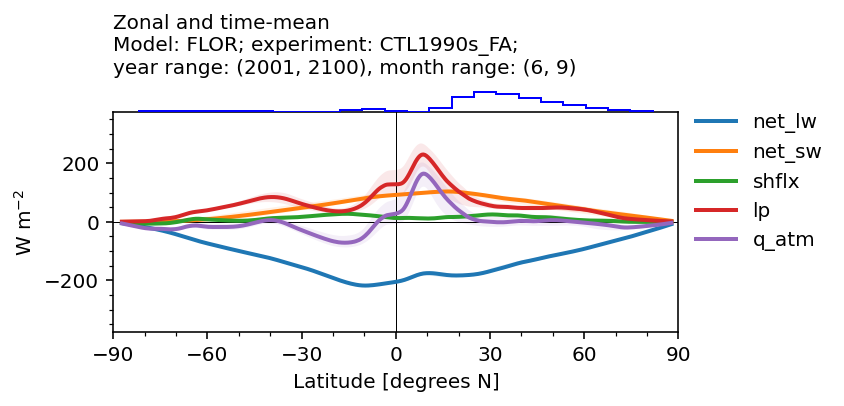

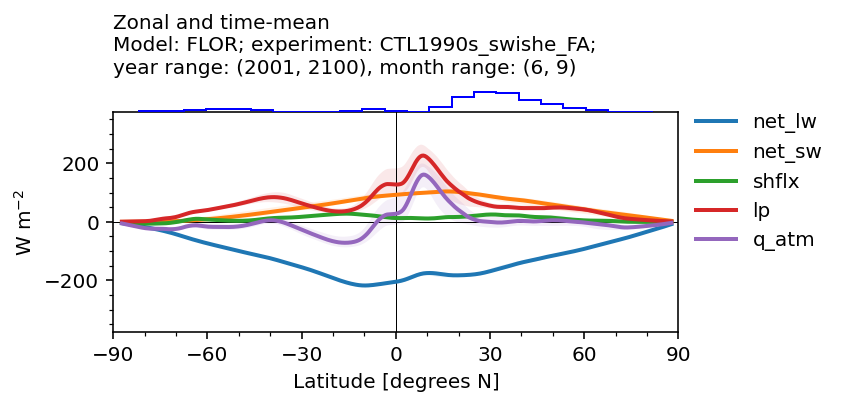

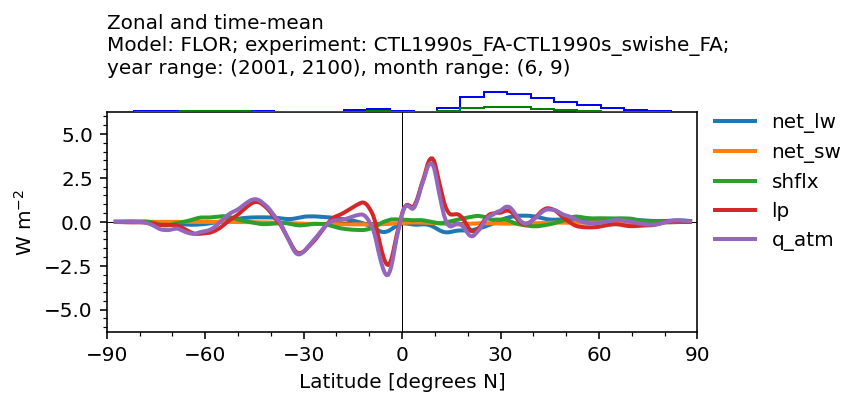

In [96]:
fields = ['net_lw', 'net_sw', 'shflx', 'lp', 'q_atm']
conserved_field = None

for experiment in [experiment_CTL, experiment_EXP, experiment_DIFF]:
    difference_experiment = True if experiment == experiment_DIFF else False
    zonal_average_radiation = zonal_mean(data, 
                                         model_name, 
                                         experiment, 
                                         fields, 
                                         month_range=month_range,
                                         difference_experiment=difference_experiment, conserved_field=conserved_field)

    # Conservation check
    if conserved_field is not None:
        dataset = zonal_average_radiation['mean'][conserved_field]
        area_weighted_dataset = utilities.latitude_weighting(dataset) * dataset
        print('Conserved field: {0} global mean = {1:.2f} {2} for experiment {3}'.format(conserved_field, area_weighted_dataset.mean(), dataset.attrs['units'], experiment))

#### Surface moisture flux

FLOR CTL1990s_FA (2001, 2100)
Loading data for FLOR, experiment CTL1990s_FA from /projects/GEOCLIM/gr7610/analysis/tc_storage/track_data/TC_track_data.s1901_e2100.model_FLOR.experiment_CTL1990s_FA.pkl...
-------------------------------------------------------------
Statistics for TCs in model: FLOR; experiment: CTL1990s_FA
Number of storms: 2454
Storm duration: mean = 8.27 +/- 4.31 days
Storm maximum winds: mean = 27.44 +/- 5.26 m/s
Storm minimum pressure: mean = 981.85 +/- 16.00 hPa
-------------------------------------------------------------

FLOR CTL1990s_swishe_FA (2001, 2100)
Loading data for FLOR, experiment CTL1990s_swishe_FA from /projects/GEOCLIM/gr7610/analysis/tc_storage/track_data/TC_track_data.s2001_e2100.model_FLOR.experiment_CTL1990s_swishe_FA.pkl...
-------------------------------------------------------------
Statistics for TCs in model: FLOR; experiment: CTL1990s_swishe_FA
Number of storms: 839
Storm duration: mean = 8.40 +/- 4.63 days
Storm maximum winds: mean = 22.

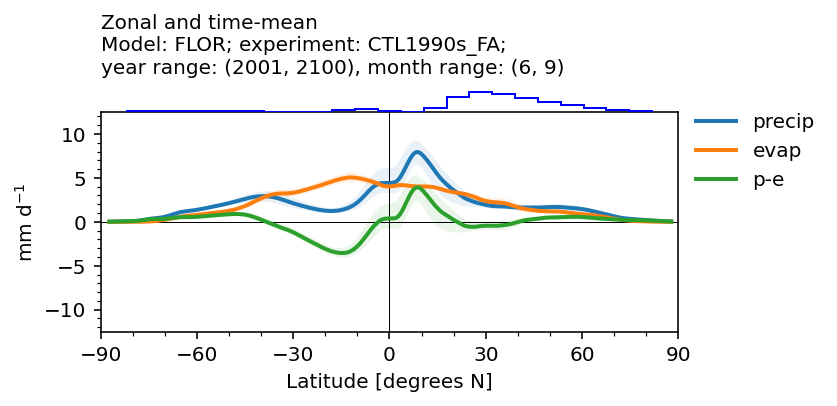

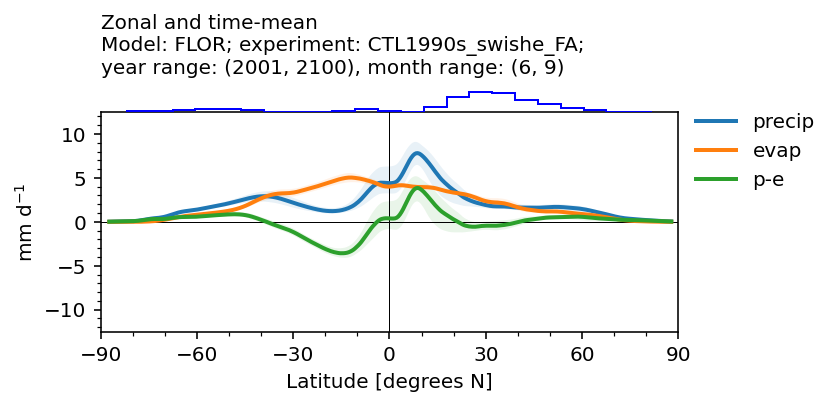

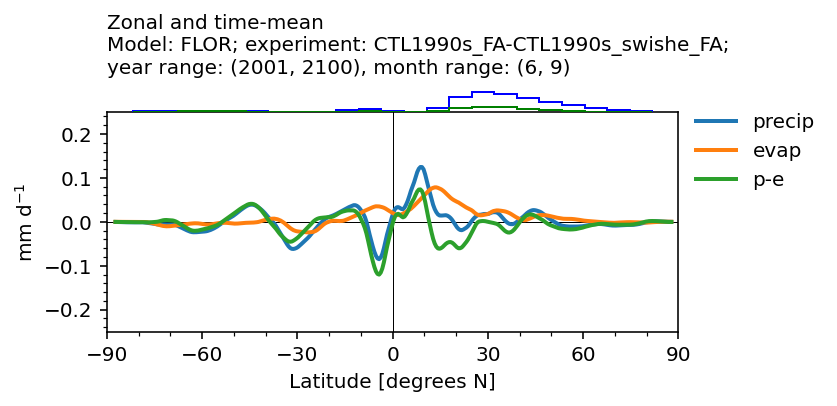

In [97]:
fields = ['precip', 'evap', 'p-e']
conserved_field = None

for experiment in [experiment_CTL, experiment_EXP, experiment_DIFF]:
    difference_experiment = True if experiment == experiment_DIFF else False
    zonal_average_radiation = zonal_mean(data, 
                                         model_name, 
                                         experiment, 
                                         fields, 
                                         month_range=month_range, 
                                         difference_experiment=difference_experiment, 
                                         conserved_field=conserved_field)

    # Conservation check
    if conserved_field is not None:
        dataset = zonal_average_radiation['mean'][conserved_field]
        area_weighted_dataset = utilities.latitude_weighting(dataset) * dataset
        print('Conserved field: {0} global mean = {1:.2f} {2} for experiment {3}'.format(conserved_field, area_weighted_dataset.mean(), dataset.attrs['units'], experiment))